In [1]:
# dataset_id = 212 = trigger auf scintaillator TDCh49 = upstream scintillator
#########################################################################
#dataset_id = "7_GO4spikerej_scan"
# = "8b_ptimeVsthresh_scan_gain4"
dataset_id = "ID23_dcdc_noiseONOFF_HIghBeam"




# MDC settings:
HV=1750
# set data taking time in seconds for each step, minimum 90s is needed to initialize and get some trigger from dabc stream
data_taking_duration = 60*10
# set PASTTREC settings:
# peakintime: 10, 15, 20 (ns)
# gain: 1, 2, 4
# threshold: 1,2,3 .... 127
# spike rejection 10 ,15, 20 ,33,99 all int possible (ns)

ptime_list = [ 10 ]
#ptime_list = [   10 ]
# set PASTTREC default threshold for the measurement
pt_gain_list = [   4 ]
#pt_gain_list = [ 4 , 2, 1 ]  
#pt_threshold_list = [ 5 , 7, 9 ]
pt_threshold_list = [ 5]
#pt_threshold_list = [5,7,9,11,13,15,17,19,21,23,25,27]
#pt_threshold_list = [5,11,17, 23,27]
spike_reject_list = [0]
spike_reject_list_TDC = [0]
#spike_reject_list_TDC = [0,1,2,3,4,5,6,7,8]
if data_taking_duration< 90:
    wait_for_beam = True
else:
        wait_for_beam = False
#time windows:
t1_min = -500
t1_max = 200
#t1_min = -5000
#t1_max = 5000
#1. scintillator upstream
#ref_channel = 35049
#2. scintillator downstream
ref_channel = 35050

spillbreak_rate_scintillator = 3000
board_list = [ "0900", "0901","0902","0903","0904", "0905","0906","0907"]
boards_to_activate_on_one_step = 1
TDClist = ["0x1800","0x1801","0x1802","0x1803"]
number_of_TDC_channels = 10

#time trend:
trendduration = 1*60*60
stepduration = 60

name = board_list[0]
import os
os.system("trbcmd loadbit {} 0xd580 0x300 0x{}00".format("0x1800", 2))
os.system("trbcmd loadbit {} 0xd580 0x300 0x{}00".format("0x1803", 0))
# COSY May2021 beam position:
os.system("trbcmd loadbit {} 0xd580 0x300 0x{}00".format("0x1801", 0))
os.system("trbcmd loadbit {} 0xd580 0x300 0x{}00".format("0x1802", 2))
#setTDC spike rejection to ~50ns 
os.system("trbcmd loadbit 0x1801 0xd580 0xf0000000 0x70000000")

#switch off DCDC converter nex to TDC1802 & 1803, which is there to check influence on noise
import hameg_lv as hMBO 
hMBO.set_state(1,0) 
#disable trigger rate limit, run with full rate
#os.system("trbcmd w 0xc035 0xa00c 0x80000014")  # cts_throttle: enable=false, stop=false, threshold=20
#os.system("trbcmd clearbit 0xc035 0xa00c 0x80000000") # Enable all triggers

# configure Coincidenc logic: channels 48 (0x30) & 49  (0x31)
os.system("trbcmd w  0x0350 0xdf40  0x80003130")
# set output channel of coincidence signal :
os.system("trbcmd w  0x0350 0xdf34  0x20000")
# set coincidence signal to trigger input FPGA Inputs1
os.system("trbcmd w 0xc035 0xa150 0x00000004")  # trg_periph_config1: mask=0000 0000 0000 0000 0100
# activate coincidence trigger only:
os.system("trbcmd w 0xc035 0xa101 0xffff0800")
# activate scintillator1 trigger (ch49) only:
#os.system("trbcmd w 0xc035 0xa101 0xffff0400")  # trg_channel_mask: edge=1111 1111 1111 1111, mask=0000 0100 0000 0000

## define sequence of boards to activate in scan.
#boards_scan_list = board_list
boards_scan_list =   [ "0902","0902","0902" ]
total_measure_duration = data_taking_duration*len(spike_reject_list)*len(spike_reject_list_TDC)*len(ptime_list)*len(pt_gain_list)*len(pt_threshold_list)*len(boards_scan_list)/boards_to_activate_on_one_step
message = " total time estimated [h] = {:.2f} = [min] = {:.2f} ".format(total_measure_duration/3600,total_measure_duration/60)
print(message)


 total time estimated [h] = 0.50 = [min] = 30.00 


In [2]:


import ROOT
import os
from my_utils import *
set_width_max_of_jupyterpad()

from fst import *
import numpy as np
import db 
import pasttrec_ctrl as ptc
import baseline_calib

data_dir = make_data_dir()

#from ROOT import gInterpreter, gSystem
#gInterpreter.ProcessLine('#include "/workdir/my_event.h"')

import tdc_daq as td


print(data_dir)
for my_board in db.board_list():
    db.enable_board(my_board)    
    #db.unset_standby_board(my_board)
    db.set_standby_board(my_board)    
    #db.disable_board(my_board)
    ptc.init_board_by_name(my_board)
    ptc.set_threshold_for_board_by_name(my_board,5)

ptc.init_active_boards()
td.enable_tdc_channels_of_active_boards()

#set spike rejection for pasttrec tdc channels:
#setup = db.get_setup_json()
#setup["global_settings"]["spike_rejection"] = 33
#print( setup["global_settings"]["spike_rejection"] )
#db.write_setup_json(setup)
#db.write_go4_settings_h()


Welcome to JupyROOT 6.14/04


/workdir/jupyter/Cosy2021_tot_data_taking_data


In [3]:
##################################################
##   clear data dir, copy root file or measure fresh    ##
##################################################
import hameg_trb 
import os 
import scalers
# boards_scan_list = ['0110', '0011', '0010', '0015', '0016', '0009', '0017', '0020', '0023', '0030', '0110', '0029', '0002', '0027', '0101', '0025', '0004', '0026', '0022', '0003', '0014', '0021', '0018', '0104', '0006', '0028', '0103', '0102', '0008', '0005']
#boards_scan_list = ['0010', '0101', '0011', '0002', '0009', '0004', '0015', '0027', '0016', '0025', '0017', '0026', '0022', '0020', '0003', '0023', '0030', '0014', '0021', '0029', '0018', '0104', '0103', '0006', '0008', '0102', '0028']
#boards_scan_list = ['0010', '0011', '0009', '0015', '0016', '0017', '0020', '0023', '0030', '0029', '0101', '0002', '0004', '0027', '0025', '0026', '0022', '0003', '0014', '0021', '0018', '0104', '0006', '0028']
# boards_scan_list = ['0010', '0009', '0011', '0015', '0016', '0017', '0020', '0023', '0030', '0029', '0027', '0002', '0004', '0025', '0026', '0022', '0003', '0014', '0021', '0018', '0006', '0028', '0008', '0005']
#boards_scan_list = ['0014', '0005', '0021', '0022', '0025', '0003', '0026', '0027', '0008', '0004', '0002', '0101', '0029', '0030', '0028', '0023', '0020', '0017', '0016', '0006', '0015', '0010', '0011', '0009']

data_file_list = []
current_list = []
volt_list = []
current_list2 = []
volt_list2 = []

tdc_channels = list(range(0, number_of_TDC_channels))
scaler_list_trend_channel = [ []  for i in range(16)] 
scinti_rate = [[] for i in range(0,2)]
    
#for my_board in db.board_list():
#            db.unset_standby_board(my_board)
 
print(message)
alert(message)
#for timestep in range(0,ntimesteps):
for spike_reject in spike_reject_list:
 setup = db.get_setup_json()
 setup["global_settings"]["spike_rejection"] = spike_reject
 setup["global_settings"]["t1_L"] =     t1_min
 setup["global_settings"]["t1_R"] =     t1_max
 setup["global_settings"]["reference_channel"] =     ref_channel    
 db.write_setup_json(setup)
 db.write_go4_settings_h()

 for spike_reject_TDC in spike_reject_list_TDC:
 #setTDC spike rejection to ~50ns 
  os.system("trbcmd loadbit 0x1801 0xd580 0xf0000000 0x{:d}0000000".format(spike_reject_TDC))

 #for ptime in channelswitchlist:
  # for tdc in TDClist:
      #  print("trbcmd loadbit {} 0xd580 0x300 0x{}00".format(tdc, ptime))
   #     os.system("trbcmd loadbit {} 0xd580 0x300 0x{}00".format(tdc, ptime))
  for ptime in ptime_list: 
   for pt_gain in pt_gain_list:     
    for pt_threshold in pt_threshold_list:    
     for my_board in db.board_list():
        db.set_standby_board(my_board)
     import random
     random.shuffle(boards_scan_list)
     iboard = -boards_to_activate_on_one_step
     for p in range(0,int(len(boards_scan_list)/boards_to_activate_on_one_step)): 
        iboard += boards_to_activate_on_one_step
        # switch on noise from DCDC board:
        import hameg_lv as hMBO 
        if p == 1:
            hMBO.set_state(1,0) 
        else:
             hMBO.set_state(1,1)
        hMBO.report()
        for my_board in db.board_list():
            for p_act in range(0,boards_to_activate_on_one_step):
                if my_board == boards_scan_list[iboard+p_act]:
                    db.unset_standby_board(my_board)
                    db.enable_board(my_board)
                    print("activate board: ",my_board)
        # enable data taking boards:
#         print("enable data taking boards")
        for my_board in board_list:
            db.unset_standby_board(my_board)
            db.enable_board(my_board)
        td.enable_tdc_channels_of_active_boards()
       # ptc.init_boards_by_name(db.board_list())    
        #ptc.init_active_boards()
#         print("init")
        ptc.init_boards_by_name(board_list, ptime, pt_gain, pt_threshold)   
                        # init_boards_by_name(board_list,pktime=-1,gain=-1,threshold=-1):
#         print("threshold")        
        for name in board_list:
            #baseline_calib.set_baselines_individual(name, [-15]*16 )   
            ptc.set_threshold_for_board_by_name(name,pt_threshold)
        # startr measurements, with spill start:
        if wait_for_beam:
                wait_for_spill_break(threshold_rate=spillbreak_rate_scintillator)
                wait_for_spill(threshold_rate=spillbreak_rate_scintillator)
#         print(hameg_trb.get_curr(3), hameg_trb.get_curr(4))
        scaler_rates = td.scaler_rate_of_TDC("0x1801",tdc_channels,5) 
        for ch in range(0,len(scaler_rates)):
                    scaler_list_trend_channel[ch] += [ scaler_rates[ch] ]
        #scaler_rates = td.scaler_rate_of_board(name,2) 
        #tdc_daq.scaler_rate(TDC,channels,scan_time)[ch]
        #take_data(events=20000)
        # uses only trigger by TDC 0350 channel 49 as the reference. 
        # either Scitillator inpot or puls generator input to this channel, needs to be used
        print("start data taking: peaking time_{:d}, threshold_{:d}, gain_{:d} # of boards active_{:d}, offline spike rejection_{:d}, TDC spike rejection_{:d}".format(ptime,pt_threshold,pt_gain,iboard,spike_reject,spike_reject_TDC))
        import datetime
        now = datetime.datetime.now()
        print("Starting now {:s} ".format(str(datetime.datetime.now())))
        
#         upstream = scalers.scaler_rate("0x0350",[49],4)
#         downstream = scalers.scaler_rate("0x0350",[50],4)
        scinti_rate[0] += scalers.scaler_rate("0x0350",[49],4)
        scinti_rate[1] += scalers.scaler_rate("0x0350",[50],4)
        #print("beam intensity measured by scintillator rates: upstream ="+scinti_rate[0]+", downstream = "+downstream )
        startttime=datetime.datetime.now()
        print("Starting now {:s} ".format(str(datetime.datetime.now())))
        take_data(time=data_taking_duration)
        print("stopped now {:s} ".format(str(datetime.datetime.now())))
        print(datetime.datetime.now()-startttime)
        #import time as time
        #time.sleep(5) # prevents crashing the trbsystem (probably only needed with high traffic, while low thresholds ...) 
        
        
        current_list += [ hameg_trb.get_curr(3) ]
        volt_list += [ hameg_trb.get_volt(3) ]
        current_list2 += [ hameg_trb.get_curr(4) ]
        volt_list2 += [ hameg_trb.get_volt(4) ] 

        print(hameg_trb.get_curr(3), hameg_trb.get_curr(4))
     # clear_data_dir()
        data_file = "{:s}/ID{:s}_HV{:d}V_ptime_{:d}_thr_{:d}_gain_{:d}_boardsON_{:d}_sr_{:d}_srTDC_{:d}.root".format(data_dir,dataset_id,HV,ptime,pt_threshold,pt_gain,iboard,spike_reject,spike_reject_TDC)
        print("data file written: ", data_file)
        #os.system("cp /workdir/tree_out.root {:s}".format(data_file))
        os.system("cp /workdir/joint_tree.root {:s}".format(data_file))
        data_file_list.append(data_file)

  # write data file list to disk, for later analysis
import pickle
with open("{:s}/datasetID_{:s}_list.pickle".format(data_dir,dataset_id), 'wb') as fp:
    pickle.dump(data_file_list, fp)  
print(fp)

 total time estimated [h] = 0.50 = [min] = 30.00 


device: /dev/ttyUSB_HAMEG_LV
volt 3.621000 curr 0.020600 state 1
volt 5.001000 curr 0.038900 state 1
volt 4.000000 curr 2.117000 state 1
volt 1.799000 curr 2.226000 state 1
activate board:  0902
start data taking: peaking time_10, threshold_5, gain_4 # of boards active_0, offline spike rejection_0, TDC spike rejection_0
Starting now 2021-05-22 00:13:05.297125 
Starting now 2021-05-22 00:13:13.367941 
stopped now 2021-05-22 00:24:05.221186 
0:10:51.860115
0.0098 0.0992
data file written:  /workdir/jupyter/Cosy2021_tot_data_taking_data/IDID23_dcdc_noiseONOFF_HIghBeam_HV1750V_ptime_10_thr_5_gain_4_boardsON_0_sr_0_srTDC_0.root
device: /dev/ttyUSB_HAMEG_LV
volt 0.000000 curr 0.000000 state 0
volt 5.000000 curr 0.037000 state 1
volt 4.000000 curr 2.122000 state 1
volt 1.800000 curr 2.273000 state 1
activate board:  0902
start data taking: peaking time_10, threshold_5, gain_4 # of boards active_1, offline spike rejection_0, TDC spike rejection_0
Starting now 2021-05-22 00:24:12.781528 
Starti

rm: cannot remove '*.root': No such file or directory
Info in <TUnixSystem::ACLiC>: creating shared library /workdir/./first_C.so
Info in <TUnixSystem::ACLiC>: creating shared library /workdir/./second_C.so
rm: cannot remove '*.root': No such file or directory
Info in <TUnixSystem::ACLiC>: creating shared library /workdir/./first_C.so
Info in <TUnixSystem::ACLiC>: creating shared library /workdir/./second_C.so
rm: cannot remove '*.root': No such file or directory
Info in <TUnixSystem::ACLiC>: creating shared library /workdir/./first_C.so
Info in <TUnixSystem::ACLiC>: creating shared library /workdir/./second_C.so


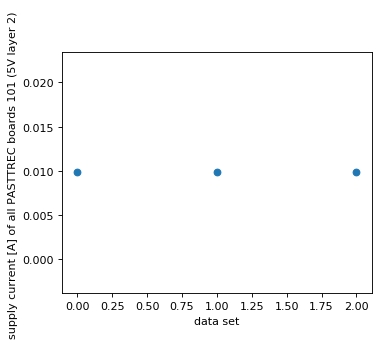

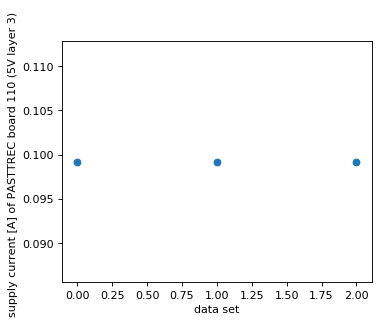

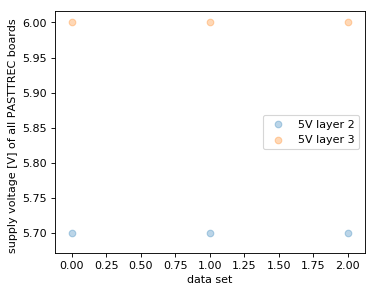

In [4]:

from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(num=None, figsize=(5, 4), dpi=80, facecolor='w', edgecolor='k')        
plt.scatter(range(0,len(current_list)),current_list)    
plt.xlabel("data set")
plt.ylabel("supply current [A] of all PASTTREC boards 101 (5V layer 2) ")
plt.show()
plt.figure(num=None, figsize=(5, 4), dpi=80, facecolor='w', edgecolor='k') 
plt.scatter(range(0,len(current_list2)),current_list2)        
plt.xlabel("data set")
plt.ylabel("supply current [A] of PASTTREC board 110 (5V layer 3) ")
plt.show()

plt.figure(num=None, figsize=(5, 4), dpi=80, facecolor='w', edgecolor='k') 
plt.scatter(range(0,len(volt_list)),volt_list,alpha=0.3,label = "5V layer 2")
plt.scatter(range(0,len(volt_list2)),volt_list2,alpha=0.3,label = "5V layer 3")      
plt.xlabel("data set")
plt.ylabel("supply voltage [V] of all PASTTREC boards  ")
plt.legend()
plt.show()

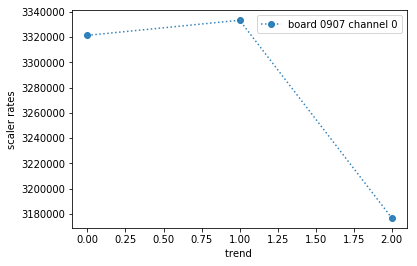

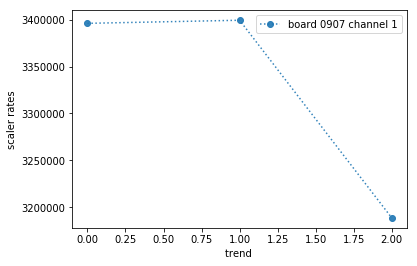

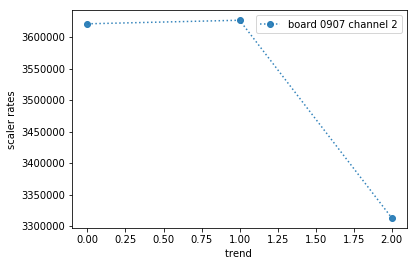

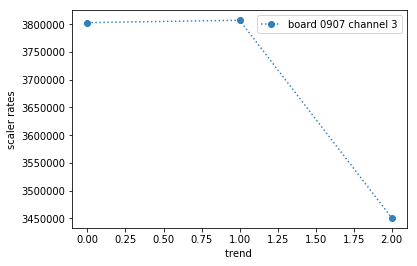

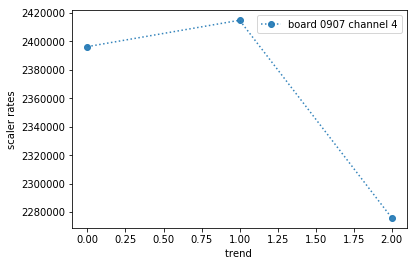

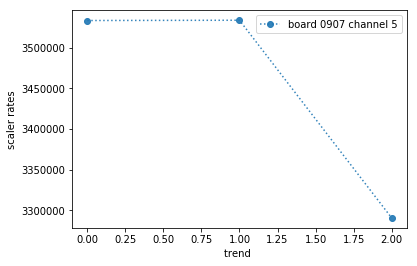

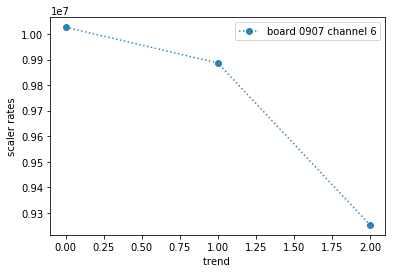

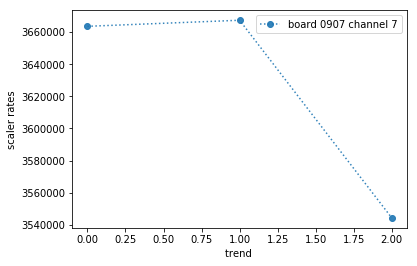

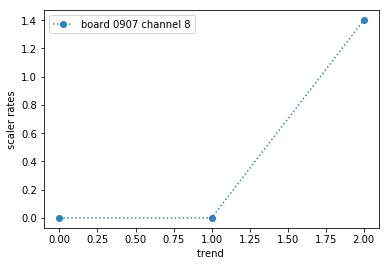

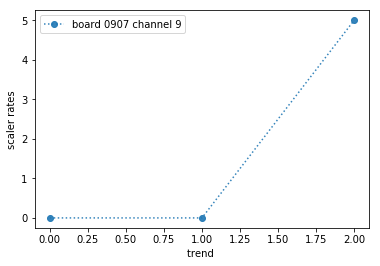

No handles with labels found to put in legend.


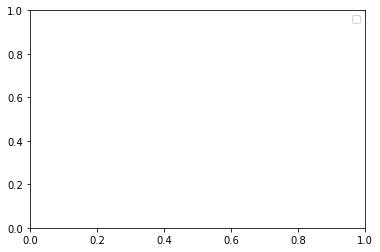

No handles with labels found to put in legend.


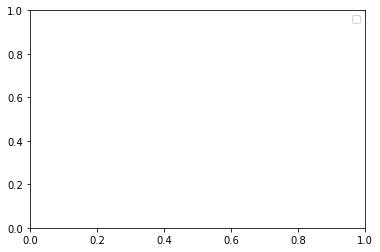

No handles with labels found to put in legend.


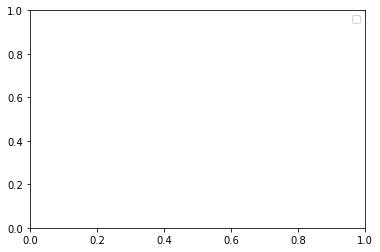

No handles with labels found to put in legend.


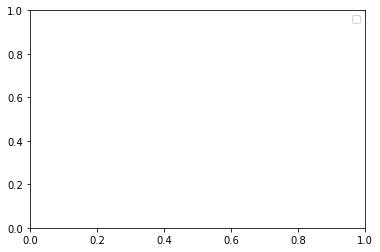

No handles with labels found to put in legend.


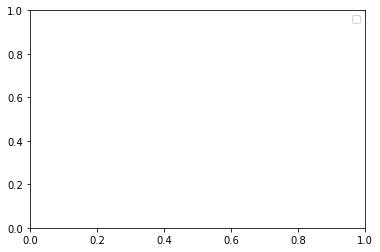

No handles with labels found to put in legend.


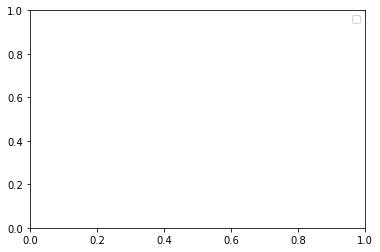

In [5]:
 
for ch in range(0,len(scaler_list_trend_channel)):
    if scaler_list_trend_channel[ch]:
            plt.errorbar(range(0,len(scaler_list_trend_channel[ch])),scaler_list_trend_channel[ch], yerr=None, xerr=None, fmt='o:', alpha=0.9,label = "board {:s} channel {:d}".format(name,ch))
            plt.xlabel("trend ")
            plt.ylabel("scaler rates")  
    plt.legend()
    plt.show()

In [6]:
  # write data file list to disk, for later analysis
import pickle 
with open("{:s}/datasetID_{:s}_list.pickle".format(data_dir,dataset_id), 'wb') as fp:
    pickle.dump(data_file_list, fp)  
print(fp)
alert("finished")

<_io.BufferedWriter name='/workdir/jupyter/Cosy2021_tot_data_taking_data/datasetID_ID23_dcdc_noiseONOFF_HIghBeam_list.pickle'>


In [7]:
# archive(label="ID_{:s}_tot_data_cosy2021_lena_newMBOs".format(dataset_id))


#list_file ="/workdir/jupyter/Cosy2021_tot_data_taking_data/datasetID_11_gainscan_spikerejVer5_highbeamintensity_list.pickle"
#list_file ="ID10_gainscan_spikerejVer5_NoBeamNoise_HV1750V_ptime_10_thr_5_gain_4_boardsON_0_sr_0"
# if ".pickle" in list_file:
#     with open (list_file,'rb') as fp:
#      data_file_list = pickle.load(fp) 
# print(data_file_list)


data file   , tot_mostprob signalcounts noisecounts sn_ratio significance
/workdir/jupyter/Cosy2021_tot_data_taking_data/IDID23_dcdc_noiseONOFF_HIghBeam_HV1750V_ptime_10_thr_5_gain_4_boardsON_0_sr_0_srTDC_0.root
Cosy2021_tot_data_taking_data/IDID23_dcdc_noiseONOFF_HIghBeam_HV1750V_ptime_10_thr_5_gain_4_boardsON_0_sr_0_srTDC_0. |  22.5 |  7298.0 |  5865.0 |  1.24 |  63.61
/workdir/jupyter/Cosy2021_tot_data_taking_data/IDID23_dcdc_noiseONOFF_HIghBeam_HV1750V_ptime_10_thr_5_gain_4_boardsON_1_sr_0_srTDC_0.root
Cosy2021_tot_data_taking_data/IDID23_dcdc_noiseONOFF_HIghBeam_HV1750V_ptime_10_thr_5_gain_4_boardsON_1_sr_0_srTDC_0. |  22.5 |  7717.0 |  6386.0 |  1.21 |  64.98
/workdir/jupyter/Cosy2021_tot_data_taking_data/IDID23_dcdc_noiseONOFF_HIghBeam_HV1750V_ptime_10_thr_5_gain_4_boardsON_2_sr_0_srTDC_0.root
Cosy2021_tot_data_taking_data/IDID23_dcdc_noiseONOFF_HIghBeam_HV1750V_ptime_10_thr_5_gain_4_boardsON_2_sr_0_srTDC_0. |  22.5 |  7315.0 |  6556.0 |  1.12 |  62.11


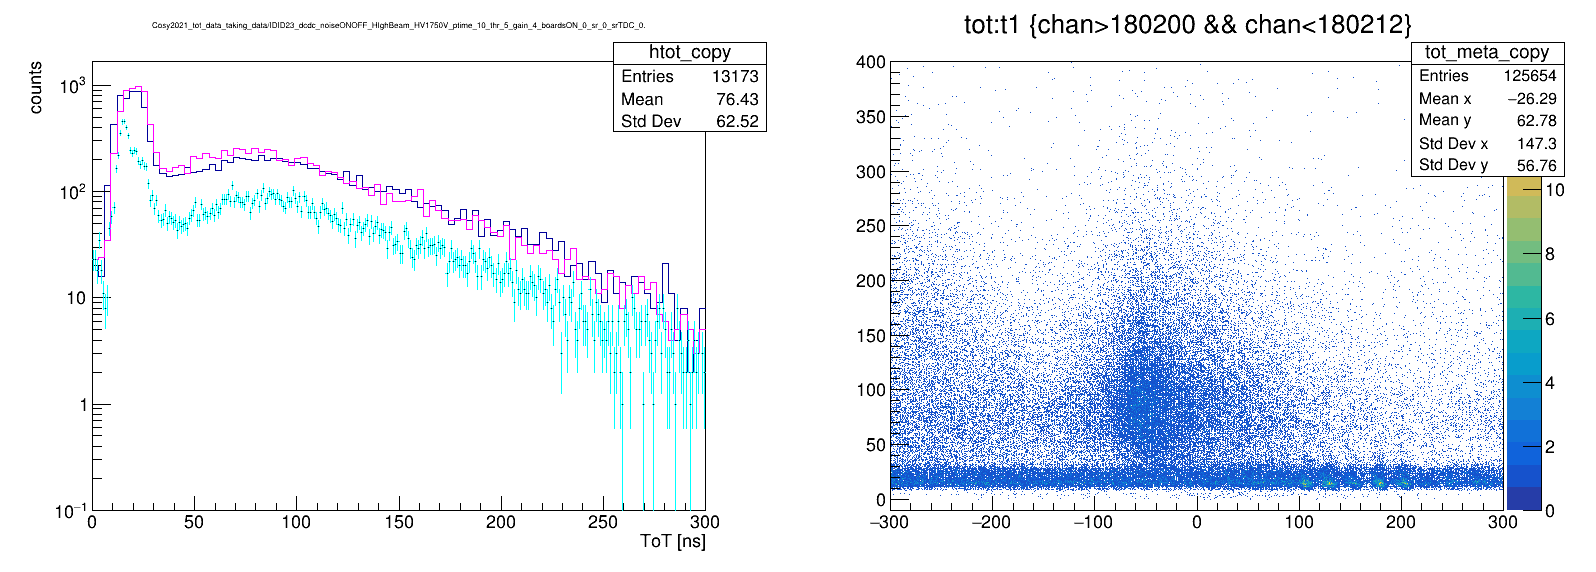

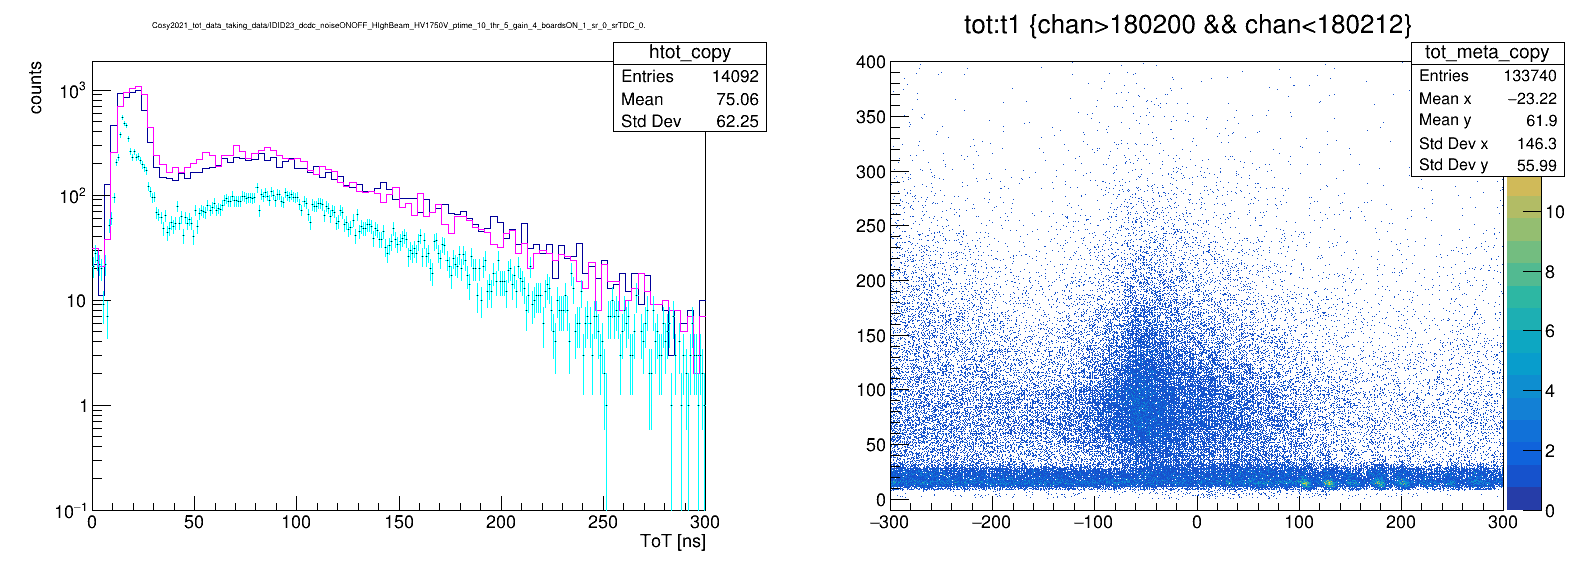

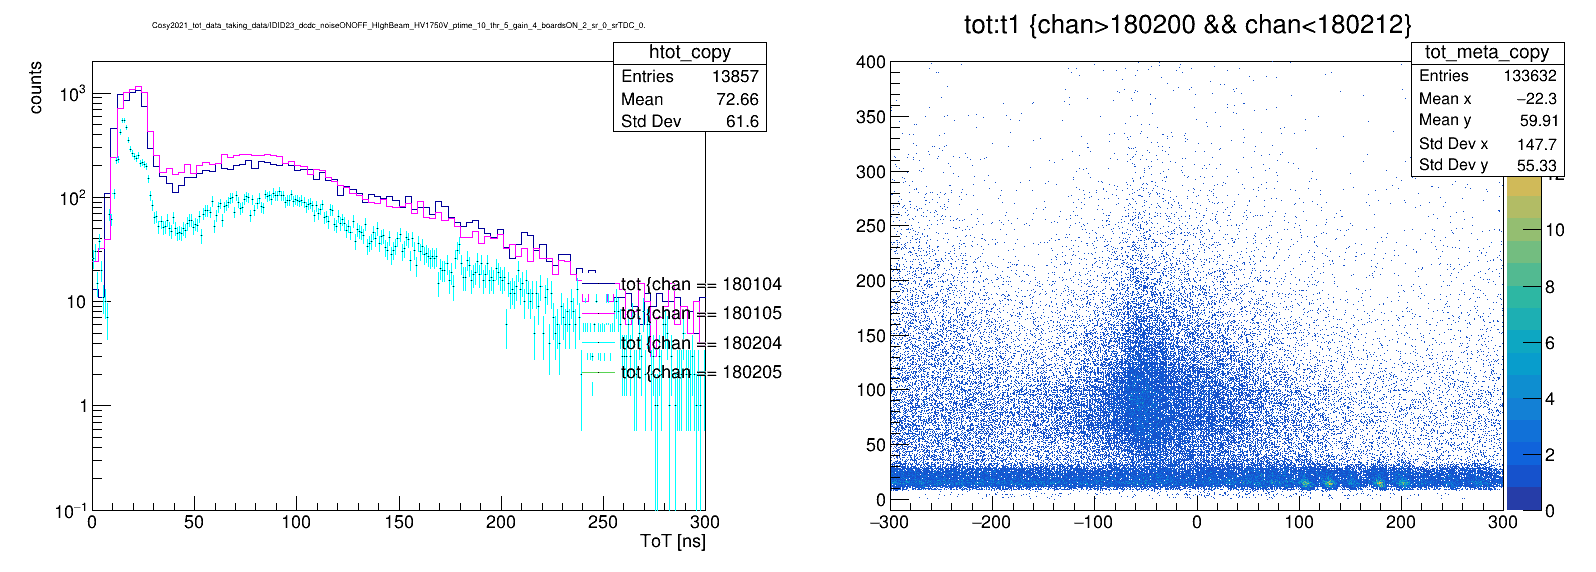

In [20]:

##################################################
##               slurp root file                ##
##################################################
 
#with open ('/workdir/jupyter/tot_data_taking_data/HV1600V_ptime_15_threshold_50_gain_4_boardsON_23.rootlist.pickle', 'rb') as fp:

    

#f = ROOT.TFile("/workdir/tree_out.root".format(data_dir))
#tree = f.Get("TDC_1503")
#print("data entries TDC_1503: " + str(tree.GetEntries()))
i = -1
clist = [None]*100
print("data file   ,", "tot_mostprob", "signalcounts", "noisecounts", "sn_ratio", "significance")
    
for data_file in data_file_list:
    i += 1
    print(data_file)
    f = ROOT.TFile("{:s}".format(data_file))
    #f = ROOT.TFile("{:s}".format("/workdir/tree_out.root"))    
    tree = f.Get("joint_tree")
    #tree = f.Get("TDC_1800")
    #print("data entries: " + str(tree.GetEntries()))
    ## plot data:
    clist[i] = ROOT.TCanvas("myCanvasName"+str(i),str(data_file),1600,600)
    clist[i].Divide(2,1)
    clist[i].cd(1)    
    #tree.Draw("tot>>htot(300,0,300)","chan > 150300 && chan < 150316")
    #tree.Draw("tot>>htot2(300,0,300)","chan > 035300 && chan < 035316","same")   
    tree.Draw("tot>>htot3(300,0,300)","chan == 180204") 
    tree.Draw("tot>>htot4(300,0,300)","chan == 180205") 
    #tree = f.Get("TDC_1503")
    #tree.Draw("tot>>htot2(300,0,1000)","chan > 00") 
    #tree.Draw("tot>>htot3(100,0,600)","chan > 180000 && chan < 180099")  
    #tree.Draw("tot>>htot2(100,0,600)","chan > 180100 && chan < 180199") 
    #tree.Draw("tot>>htot3(100,0,600)","chan > 180200 && chan < 180299") 
    #tree.Draw("tot>>htot2(100,0,600)","chan > 180300 && chan < 180399")  
    #tree.Draw("tot>>htot3(100,0,600)","chan > 0") 
    #tree.Draw("tot>>htot4(100,0,600)","chan > 150300 && chan < 150399")    
    tree.Draw("tot>>htot2(100,0,300)","chan == 180105") 
    tree.Draw("tot>>htot(100,0,300)","chan == 180104")
    clist[i].Draw()
    htot = f.Get("htot")
    htot2 = f.Get("htot2")
    htot3 = f.Get("htot3")
    htot4 = f.Get("htot4")    
    
    htot.GetXaxis().SetTitle("ToT [ns]")
    htot.GetYaxis().SetTitle("counts")
    leg = ROOT.TLegend(.73,.32,.97,.53)
    leg.SetBorderSize(0)
    leg.SetFillColor(0)
    leg.SetFillStyle(0)
    leg.SetTextFont(42)
    leg.SetTextSize(0.035)
    leg.AddEntry(htot,htot.GetTitle());
    leg.AddEntry(htot2,htot2.GetTitle());
    leg.AddEntry(htot3,htot3.GetTitle());
    leg.AddEntry(htot4,htot4.GetTitle());     
    
    htot.SetTitle(data_file.strip("workdir/jupyter/tot_data_taking_data"))
    htot2.SetLineColor(6)
    htot.SetMinimum(0.1)
    htot.DrawCopy("")
    htot2.DrawCopy("same")
    htot3.SetLineColor(7)
    htot3.DrawCopy("e p0 same")
    htot4.SetLineColor(8)
    #htot4.DrawCopy("e p0 same")
   
    leg.Draw();
    clist[i].cd(1).SetLogy()
    clist[i].Draw()
    clist[i].cd(2)      
    tdc=1802
    disp_channels = 12
    tree.Draw("tot:t1>>tot_meta(1000,-300,300,1000,-10,400)","chan>{:d} && chan<{:d}".format(tdc*100,tdc*100+disp_channels),"colz")
    potato = f.Get("tot_meta")
    potato.DrawCopy("colz")
    clist[i].Draw()
    
    
    tot_mostprob = htot.GetXaxis().GetBinCenter(htot.GetMaximumBin())
    
    signalcounts  = htot.Integral(htot.FindBin(50),htot.GetNbinsX())
    noisecounts   = htot.Integral(1,htot.FindBin(50))
    if noisecounts == 0:
        sn_ratio = -1
        significance = -1
    else:
        sn_ratio = signalcounts/noisecounts
        significance = signalcounts/np.sqrt(signalcounts+noisecounts)
    print(  htot.GetTitle() , "| ",  tot_mostprob,"| ", signalcounts,"| ", noisecounts,"| ", "{:.2f}".format(sn_ratio),"| ", "{:.2f}".format(significance))
    


In [9]:
tot_mostprob = htot.GetXaxis().GetBinCenter(htot.GetMaximumBin())
    
signalcounts  = htot3.Integral(htot3.FindBin(40),htot3.GetNbinsX())
noisecounts   = htot3.Integral(1,htot3.FindBin(40))
print(signalcounts)
signalcounts2  = htot2.Integral(htot2.FindBin(40),htot2.GetNbinsX())
noisecounts2   = htot2.Integral(1,htot2.FindBin(40))
print(signalcounts,signalcounts2)
print(signalcounts/signalcounts2)
print(noisecounts/noisecounts2)
if noisecounts == 0:
    sn_ratio = -1
    significance = -1
else:
    sn_ratio = signalcounts/noisecounts
    significance = signalcounts/np.sqrt(signalcounts+noisecounts)
print(  htot.GetTitle() , "| ",  tot_mostprob,"| ", signalcounts,"| ", noisecounts,"| ", "{:.2f}".format(sn_ratio),"| ", "{:.2f}".format(significance))


9560.0
9560.0 8253.0
1.1583666545498608
0.9627749576988156
Cosy2021_tot_data_taking_data/IDID23_dcdc_noiseONOFF_HIghBeam_HV1750V_ptime_10_thr_5_gain_4_boardsON_2_sr_0_srTDC_0. |  22.5 |  9560.0 |  6259.0 |  1.53 |  76.01


In [10]:

c = ROOT.TCanvas("correl","correlations",640,480)


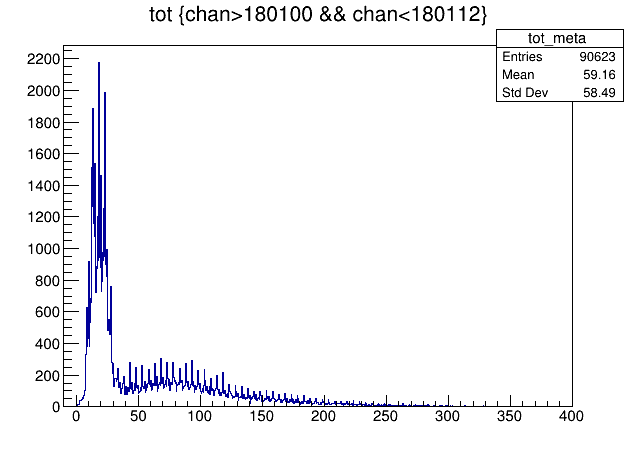

In [11]:
tdc=1801
disp_channels = 12
tree.Draw("tot>>tot_meta(1000,-10,400)","chan>{:d} && chan<{:d}".format(tdc*100,tdc*100+disp_channels))
c.Draw()

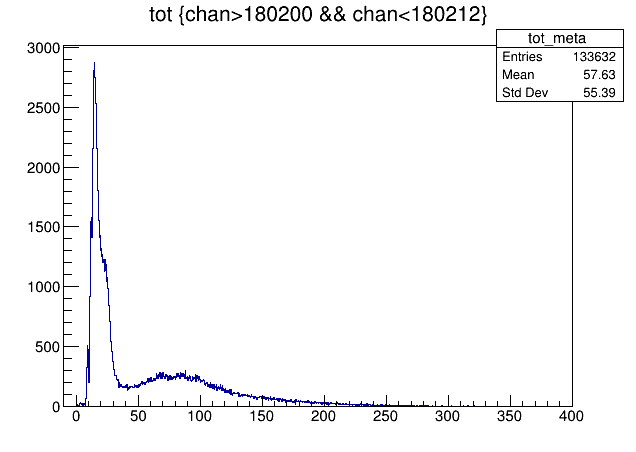

In [12]:
tdc=1802
disp_channels = 12
tree.Draw("tot>>tot_meta(1000,-10,400)","chan>{:d} && chan<{:d}".format(tdc*100,tdc*100+disp_channels))
c.Draw()

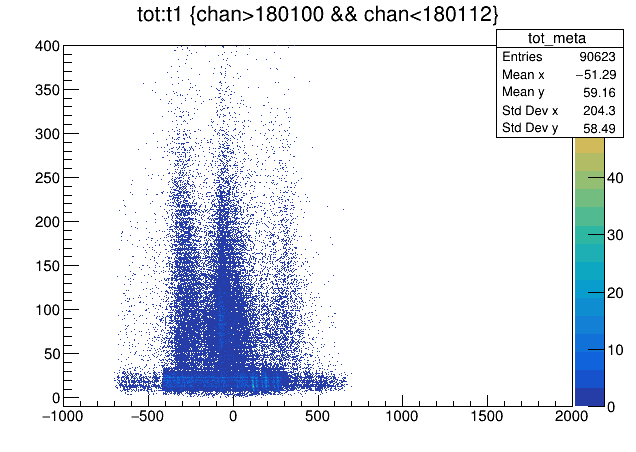

In [13]:
tdc=1801
disp_channels = 12
tree.Draw("tot:t1>>tot_meta(1000,-1000,2000,1000,-10,400)","chan>{:d} && chan<{:d}".format(tdc*100,tdc*100+disp_channels),"colz")
c.Draw()

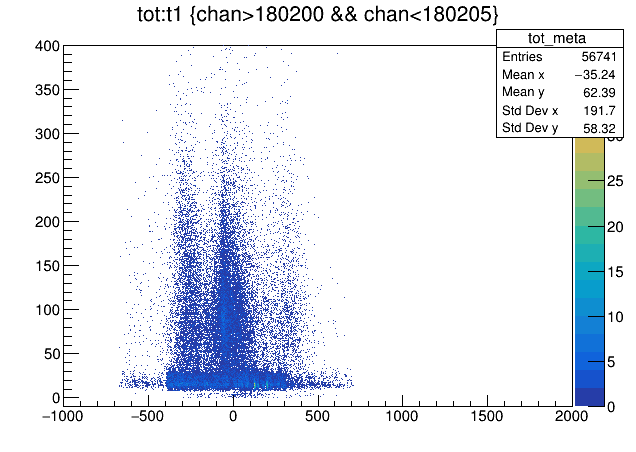

In [14]:
tdc=1802
disp_channels = 5
tree.Draw("tot:t1>>tot_meta(1000,-1000,2000,1000,-10,400)","chan>{:d} && chan<{:d}".format(tdc*100,tdc*100+disp_channels),"colz")
c.Draw()

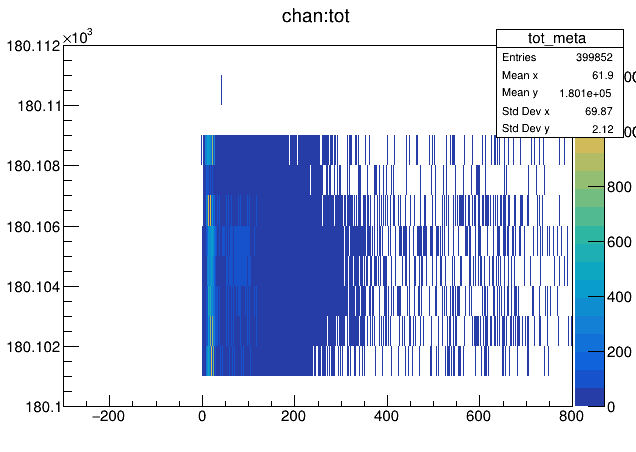

In [15]:

tdc=1801
disp_channels = 12
#tree.Draw("chan:t1","","lego2")
tree.Draw("chan:tot>>tot_meta(1000,-300,800,{:d},{:d},{:d})".format(disp_channels,tdc*100,tdc*100+disp_channels),"","colz")
c.Draw()

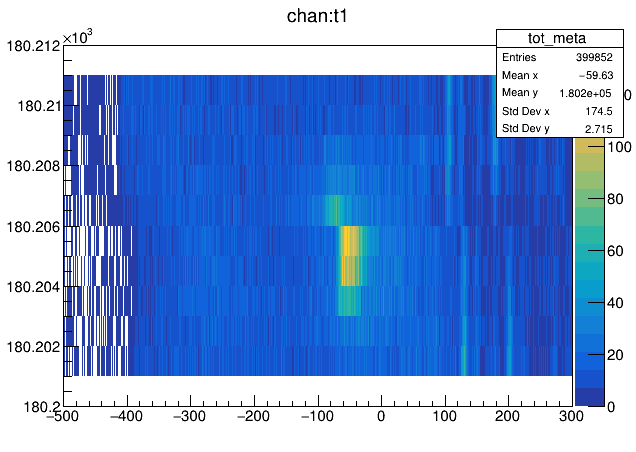

In [16]:
##################################################
##             overview TDC 0x0351              ##
##################################################
c = ROOT.TCanvas("myCanvasName","The Canvas Title",640,480)

tdc=1802
disp_channels = 12
#tree.Draw("chan:t1","","lego2")
tree.Draw("chan:t1>>tot_meta(1000,-500,300,{:d},{:d},{:d})".format(disp_channels,tdc*100,tdc*100+disp_channels),"","colz")
c.Draw()

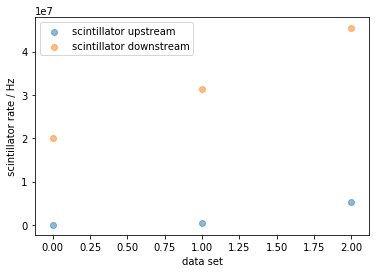

In [17]:
# plt.figure(num=None, figsize=(5, 4), dpi=80, facecolor='w', edgecolor='k') 
plt.scatter(range(0,len(scinti_rate[0])),scinti_rate[0],alpha=0.5,label = "scintillator upstream")
plt.scatter(range(0,len(scinti_rate[1])),scinti_rate[1],alpha=0.5,label = "scintillator downstream")
plt.xlabel("data set")
plt.ylabel
plt.ylabel(" scintillator rate / Hz ")
#plt.yscale('log')
plt.legend()

plt.savefig('{:s}/ID_{:s}_tot_data_cosy2021_lena_beam_intensity.png'.format(data_dir,dataset_id), dpi=100)
plt.show()



In [18]:
 
import IPython.display as ipd
import numpy

t = numpy.linspace(0, 0.5, int(0.6*24090), endpoint=False) # time variable
x = 0.5*numpy.sin(2*numpy.pi*550*t)    


ipd.Audio(x, rate=24090, autoplay=True) # load a NumPy array  


#### 

In [19]:
ipd.Audio(x, rate=5490, autoplay=True) # load a NumPy array  
